In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import time

import skopi as sk
import skopi.gpu as sg

In [18]:
# Create a particle object
particle = sk.Particle()

particle.read_pdb('../input/3iyf.pdb', ff='WK')

# Load beam
beam = sk.Beam('../input/exp_chuck.beam') 

# Load and initialize the detector
det = sk.PnccdDetector(geom = '../lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data', 
                       beam = beam)

# Calculate the 3D diffraction volume

In [19]:
mesh_length=128

# Setup the reciprocal space mesh grid for the detector
"""
The edge pixel resolution is slightly larger than the corner resolution of the detector panel.
"""
mesh, voxel_length= det.get_reciprocal_mesh(voxel_number_1d = mesh_length)

# Calculate the 3D diffraction intensity volume
volume = sg.calculate_diffraction_pattern_gpu(mesh, particle, return_type = 'intensity')


"""
Because the Intensity is very low, I would like to increase the intensity a little bit
"""
#volume *= 1e5

'\nBecause the Intensity is very low, I would like to increase the intensity a little bit\n'

# Uniformly Take 10 slices

In [21]:
# Generate 10 images uniformly over 4-sphere
orientation = sk.geometry.get_uniform_quat(num_pts=200)
ten_slices = sk.geometry.take_n_slice(pattern_shape = det.pedestal.shape,
                                      pixel_momentum = det.pixel_position_reciprocal,
                                      volume =volume,
                                      voxel_length= voxel_length,
                                      orientations= orientation)

print np.size(ten_slices,1)
print np.size(ten_slices,2)
print np.size(ten_slices,3)
print np.size(ten_slices,0)
ishape =(len(ten_slices),4,512,512)
orientation.shape
with h5.File('imStack.hdf5','w') as f:
    f.create_dataset('imUniform',shape=ishape,maxshape=ishape,data=ten_slices,dtype=np.int32)
    f.create_dataset('imOrientations',orientation.shape,data=orientation,dtype=np.float32)
with h5.File('imStack.hdf5','r') as f2:
    data2= f2['imUniform'][:] 

KeyboardInterrupt: 

In [22]:
#For example, let's say that a plane in a flight simulator 
#first performs a yaw, then a pitch, and finally a roll. 
#You can represent this combined quaternion rotation as

#q = qyaw qpitch qroll where:
#qroll = [cos (y/2), (sin(y/2), 0, 0)]  , +x
#qpitch = [cos (q/2), (0, sin(q/2), 0)] , +y
#qyaw = [cos(f /2), (0, 0, sin(f /2)]   , +clockwise

def quaternion_multiply(q,r):
    # t = q x r = t0 + it1 + jt2 + kt3
    t0 = r[0]*q[0] - r[1]*q[1] - r[2]*q[2] - r[3]*q[3]
    t1 = r[0]*q[1] + r[1]*q[0] - r[2]*q[3] + r[3]*q[2]
    t2 = r[0]*q[2] + r[1]*q[3] + r[2]*q[0] - r[3]*q[1]
    t3 = r[0]*q[3] - r[1]*q[2] + r[2]*q[1] + r[3]*q[0]
    return np.array([t0,t1,t2,t3])

ninety = np.pi/2
seventy = 70*np.pi/180
fortyfive = np.pi/4
thirty = 30*np.pi/180
twenty = 20*np.pi/180
ten = 10*np.pi/180

orientation=np.array([[1.,0.,0.,0.],
                      [np.cos(ten/2),0.,np.sin(ten/2),0.],
                      [np.cos(thirty/2),0.,np.sin(thirty/2),0.],
                      [np.cos(fortyfive/2),0.,np.sin(fortyfive/2),0.],
                      [np.cos(seventy/2),0.,np.sin(seventy/2),0.],
                      [np.cos(ninety/2),0.,np.sin(ninety/2),0.],
                      [np.cos(twenty/2),np.sin(twenty/2),0.,0.],
                      [np.cos(fortyfive/2),np.sin(fortyfive/2),0.,0.],
                      [np.cos(ninety/2),np.sin(ninety/2),0.,0.],
                      [np.cos(ten/2),0,0,np.sin(ten/2)],
                      [np.cos(twenty/2),0,0,np.sin(twenty/2)],
                      [np.cos(thirty/2),0,0,np.sin(thirty/2)],
                      [np.cos(fortyfive/2),0,0,np.sin(fortyfive/2)],
                      quaternion_multiply([np.cos(fortyfive/2),0.,np.sin(fortyfive/2),0.],[np.cos(ninety/2),np.sin(ninety/2),0.,0.]),
                      quaternion_multiply([np.cos(ninety/2),np.sin(ninety/2),0.,0.],[np.cos(thirty/2),0.,np.sin(thirty/2),0.]),                      
                     ])
a = sk.geometry.take_n_slice(pattern_shape = det.pedestal.shape,
                                      pixel_momentum = det.pixel_position_reciprocal,
                                      volume =volume,
                                      voxel_length= voxel_length,
                                      orientations= orientation)
b = det.add_correction_and_quantization_batch(pattern_batch=a)
# Assemble all the image stack
c = det.assemble_image_stack_batch(image_stack_batch=b)

Finishing constructing 15 patterns in 13.060550 seconds


In [6]:
"""
Process one image
"""
# Convert the one image to photons 
#one_photon_image = det.add_correction_and_quantization(pattern=ten_slices[0])
one_photon_image = det.add_correction_and_quantization(pattern=data2[0])
# Assemble the image stack
one_photon_2d = det.assemble_image_stack(image_stack=one_photon_image)
"""
Process all images
"""
# Convert all slices to photons
#photons = det.add_correction_and_quantization_batch(pattern_batch=ten_slices)
photons = det.add_correction_and_quantization_batch(pattern_batch=data2)
# Assemble all the image stack
photons_2d = det.assemble_image_stack_batch(image_stack_batch=photons)


no 350 found


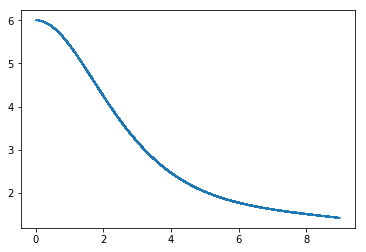

In [37]:
s=mesh.shape
pixel_number=np.prod(s[:-1])
rs1d=np.reshape(mesh,[pixel_number,3])
rn1d = np.sqrt(np.sum(np.square(rs1d), axis=-1))

p1 = sk.Particle()
p1.read_pdb('../input/carbon.pdb', ff='pmi')
import skopi.diffraction as pd
form_factor = pd.calculate_atomic_factor(particle=p1,
                                         q_space=rn1d * (1e-10 / 2.),  # For unit compatibility
                                         pixel_num=pixel_number)
plt.plot(rn1d*(1e-10/2)*(4*np.pi),form_factor[0,:]); plt.show() # q is consistant with http://lampx.tugraz.at/~hadley/ss1/crystaldiffraction/atomicformfactors/formfactors.php

#numPix = np.sqrt(512**2+512**2) # det corner
#pixSize = 75e-6
#dist = 0.15
#wavelength = 2.695e-10
#qmax=2*np.sin(np.arctan(numPix*pixSize/dist))/wavelength
#dmin=1/qmax # 3.96 A

In [38]:
1/np.max(rn1d*(1e-10/2)*np.pi*4)

0.11101071592914753

# Show the image 

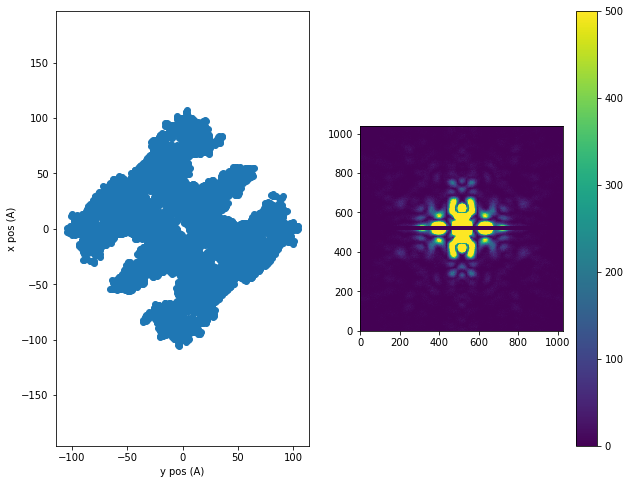

In [23]:
ind = 13 #43 #140 #170 #198
p = sk.Particle()
p.read_pdb('../input/3iyf.pdb', ff='WK')
p.rotate(orientation[ind,:])
sub = np.where(p.atom_pos[:,2]>=0)#7e-9)
fig = plt.figure(figsize=(10, 8))

plt.subplot(121)
plt.scatter(p.atom_pos[sub,1]*1e10,-1*p.atom_pos[sub,0]*1e10)
plt.xlabel('y pos (A)')
plt.ylabel('x pos (A)')
plt.xlim(-120, 120)
plt.ylim(-120, 120)
plt.axis('equal')


plt.subplot(122)
plt.imshow(c[ind,:,:],origin='lower',aspect='equal',vmin=0,vmax=500)
plt.colorbar()

plt.show()

In [200]:
rot_mat = sk.geometry.quaternion2rot3d(orientation[ind, :])
np.dot([1,0,0], rot_mat.T)

array([ 0.22188792,  0.88537192,  0.40851232])

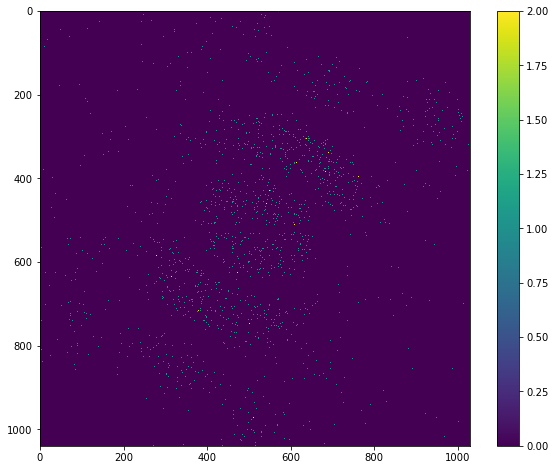

In [43]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(photons_2d[ind,:,:])#,vmin=0,vmax=10)
plt.colorbar()
plt.show()

# Take 10 random image

In [26]:
#number = 10
#for l in range(10):
orientation =sk.geometry.get_random_quat(num_pts=10)
print orientation

print np.size(orientation,0)
print np.size(orientation,1)
print det.pedestal.shape
print det.pixel_rms.shape
print det.pixel_rms.shape[0]
print sk.geometry.quaternion2rot3d(orientation[0])
#orientation = sk.geometry.get_random_orientations(num_pts=10)
ten_slices = sk.geometry.take_n_random_slices(detector= det,
                                              volume =volume,
                                              voxel_length= voxel_length,
                                              orientations=orientation )

[[ 0.38130373 -0.88216177  0.13354629  0.13354629]
 [-0.25280424  0.55729068 -0.14541872 -0.14541872]
 [-0.07768045  0.65666183 -0.59057542 -0.59057542]
 [-0.60870284 -0.43806776  0.65130558  0.65130558]
 [ 0.69485904  0.57698095 -0.13760794 -0.13760794]
 [ 0.37627641  0.2424634  -0.8862083  -0.8862083 ]
 [-0.12574896 -0.1214093   0.9349832   0.9349832 ]
 [-0.26560306 -0.41911347  0.2932836   0.2932836 ]
 [-0.6251664   0.12249611  0.65678739  0.65678739]
 [ 0.63074219 -0.59565952  0.16245915  0.16245915]]
10
4
(4, 512, 512)
(4, 512, 512)
4
[[ 0.92866155 -0.13377547 -0.33746226]
 [-0.33746226 -0.592088   -0.63707392]
 [-0.13377547  0.70841237 -0.592088  ]]
0
1
2
3


IndexError: index 2514414 is out of bounds for axis 1 with size 2097152

In [23]:
"""
Process one image
"""
# Convert the one image to photons 
one_photon_image = det.add_correction_and_quantization(pattern=ten_slices[0])

# Assemble the image stack
one_photon_2d = det.assemble_image_stack(image_stack=one_photon_image)
"""
Process all images
"""
# Convert all slices to photons
photons = det.add_correction_and_quantization_batch(pattern_batch=ten_slices)

# Assemble all the image stack
photons_2d = det.assemble_image_stack_batch(image_stack_batch=photons)


NameError: name 'ten_slices' is not defined

# Show the image

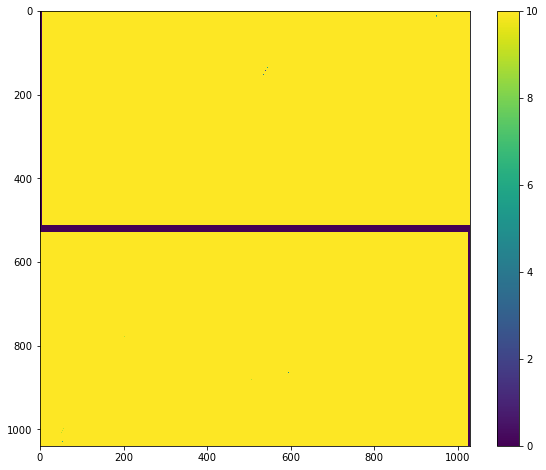

In [15]:
fig = plt.figure(figsize=(10, 8))

plt.imshow(one_photon_2d,vmin=0,vmax=10)
plt.colorbar()
plt.show()